# Bank_Marketing_classification 

#### Overview:
> The primary goal of the project is to predict whether or not a customer will subscribe to a service offered by the bank.

#### Datasets:

>The dataset contains bank marketing  collected from uci.edu: 
https://archive.ics.uci.edu/ml/datasets/bank+marketing 


#### Project proposal:
> In this project our task is get a dataset to build a classification model on. We choose to analysis a data set of a bank to determine if the customers will subscribe to a service the bank is offering.

### Importing Libraries

In [56]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler
from sqlalchemy import create_engine
from sklearn.tree import DecisionTreeClassifier
import pickle
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier


## Loading Data

In [57]:
engine = create_engine('sqlite:///bank_db.db' , echo = True)

In [58]:
all_tables = engine.table_names()
all_tables

2021-11-04 15:33:48,063 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2021-11-04 15:33:48,065 INFO sqlalchemy.engine.Engine [raw sql] ()


<ipython-input-58-9dbbbb8bc6ba>:1: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  all_tables = engine.table_names()


['bank_full', 'bank_full_updated', 'bank_full_updated1']

In [59]:
data = pd.read_sql('SELECT * FROM bank_full_updated1;', engine)
data.head()

2021-11-04 15:33:48,300 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("SELECT * FROM bank_full_updated1;")
2021-11-04 15:33:48,300 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-11-04 15:33:48,302 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("SELECT * FROM bank_full_updated1;")
2021-11-04 15:33:48,303 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-11-04 15:33:48,307 INFO sqlalchemy.engine.Engine SELECT * FROM bank_full_updated1;
2021-11-04 15:33:48,308 INFO sqlalchemy.engine.Engine [raw sql] ()


,index,age,default,balance,housing,loan,day,duration,campaign,pdays,...,month_oct,month_sep,education_primary,education_secondary,education_tertiary,education_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,0,58,0,2143,1,0,5,261,1,0,...,0,0,0,0,1,0,0,0,0,1
1,1,44,0,29,1,0,5,151,1,0,...,0,0,0,1,0,0,0,0,0,1
2,2,33,0,2,1,1,5,76,1,0,...,0,0,0,1,0,0,0,0,0,1
3,3,47,0,1506,1,0,5,92,1,0,...,0,0,0,0,0,1,0,0,0,1
4,4,33,0,1,0,0,5,198,1,0,...,0,0,0,0,0,1,0,0,0,1


In [60]:
data.drop(columns='index',inplace=True)

# Split data

In [61]:
X, y = data.drop('y',axis=1), data['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2, random_state=3)


# Baseline Model 

In [62]:
knn=KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)

accuracy_train_set = knn.score(X_train, y_train)  
accuracy_valid_set = knn.score(X_val, y_val)  


print("KNeighbors Classifier Model, Accuracy (Train Set) : ", accuracy_train_set)
print("KNeighbors Classifier Model, Accuracy (Val Set) : ", accuracy_valid_set)

KNeighbors Classifier Model, Accuracy (Train Set) :  0.9187806732563766
KNeighbors Classifier Model, Accuracy (Val Set) :  0.8661874481614598


* Handling Class Imbalance

In [63]:
data["y"].value_counts()/len(data.y)


0    0.883015
1    0.116985
Name: y, dtype: float64

In [64]:
data.drop(["duration"] , axis=1,inplace=True)
data.isnull().sum()

age                    0
default                0
balance                0
housing                0
loan                   0
day                    0
campaign               0
pdays                  0
previous               0
y                      0
job_admin.             0
job_blue-collar        0
job_entrepreneur       0
job_housemaid          0
job_management         0
job_retired            0
job_self-employed      0
job_services           0
job_student            0
job_technician         0
job_unemployed         0
job_unknown            0
marital_divorced       0
marital_married        0
marital_single         0
month_apr              0
month_aug              0
month_dec              0
month_feb              0
month_jan              0
month_jul              0
month_jun              0
month_mar              0
month_may              0
month_nov              0
month_oct              0
month_sep              0
education_primary      0
education_secondary    0
education_tertiary     0


In [65]:
#Data befor over sampling
y_train.value_counts()

0    25622
1     3312
Name: y, dtype: int64

--------------------ROS---------------------

In [66]:
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
ratio = {1 : n_pos * 4, 0 : n_neg} 

# randomly oversample positive samples: create 4x as many 
ROS =RandomOverSampler(sampling_strategy = ratio, random_state=42) 
X_tr_rand, y_tr_rand = ROS.fit_resample(X_train, y_train)
X_val_rand,y_val_rand=ROS.fit_resample(X_val,y_val)

/Users/rawan/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (13248) in class 1 will be larger than the number of samples in the majority class (class #0 -> 6348)
  warnings.warn(
/Users/rawan/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (25622) in class 0 will be larger than the number of samples in the majority class (class #0 -> 6348)
  warnings.warn(


In [67]:
print(data['y'].value_counts())
sns.countplot(x='y', data=df_new)

NameError: name 'df_new' is not defined

In [68]:
class_count_0, class_count_1 = data['y'].value_counts()

# Separate class
class_1 = data[data['y'] == 1]
class_0 = data[data['y'] == 0]# print the shape of the class
print('class 1:', class_0.shape)
print('class 0:', class_1.shape)

class 1: (39922, 45)
class 0: (5289, 45)


total class of 1 and 0: 0    39922
1    39922
Name: y, dtype: int64


Text(0.5, 1.0, 'The balance of target variable')

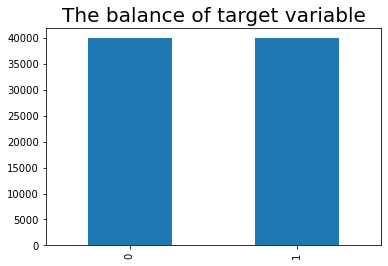

In [69]:
class_1_over = class_1.sample(class_count_0, replace=True)

test_over = pd.concat([class_0, class_1_over], axis=0)

print("total class of 1 and 0:",test_over['y'].value_counts())# plot the count after under-sampeling
test_over['y'].value_counts().plot(kind='bar', title='count (target)');
plt.title("The balance of target variable",fontsize=20)


--------------------SMOTE--------------------

In [70]:
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
ratio = {1 : n_pos * 2, 0 : n_neg}

smote =SMOTE(sampling_strategy=ratio, random_state = 42)
    
X_tr_smote, y_tr_smote = smote.fit_resample(X_train, y_train)
X_val_smote, y_val_smote = smote.fit_resample(X_val, y_val)

/Users/rawan/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (6624) in class 1 will be larger than the number of samples in the majority class (class #0 -> 6348)
  warnings.warn(
/Users/rawan/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (25622) in class 0 will be larger than the number of samples in the majority class (class #0 -> 6348)
  warnings.warn(


After over sampling

In [71]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

print('After OverSampling, the shape of train_X: {}'.format(X_tr_rand.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_tr_rand.shape))
print('After OverSampling, the shape of train_X: {}'.format(X_val_rand.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_val_rand.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_tr_rand==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_tr_rand==0)))

Before OverSampling, counts of label '1': 3312
Before OverSampling, counts of label '0': 25622 

After OverSampling, the shape of train_X: (38870, 45)
After OverSampling, the shape of train_y: (38870,) 

After OverSampling, the shape of train_X: (38870, 45)
After OverSampling, the shape of train_y: (38870,) 

After OverSampling, counts of label '1': 13248
After OverSampling, counts of label '0': 25622


After SOMTE

In [72]:
print("Before SOMTE, counts of label '1': {}".format(sum(y_train==1)))
print("Before SOMTE, counts of label '0': {} \n".format(sum(y_train==0)))

print('After SOMTE, the shape of train_X: {}'.format(X_tr_smote.shape))
print('After SOMTE, the shape of train_y: {} \n'.format(y_tr_smote.shape))
print('After SOMTE, the shape of train_X: {}'.format(X_val_smote.shape))
print('After SOMTE, the shape of train_y: {} \n'.format(y_val_smote.shape))

print("After SOMTE, counts of label '1': {}".format(sum(y_tr_smote==1)))
print("After SOMTE, counts of label '0': {}".format(sum(y_tr_smote==0)))

Before SOMTE, counts of label '1': 3312
Before SOMTE, counts of label '0': 25622 

After SOMTE, the shape of train_X: (32246, 45)
After SOMTE, the shape of train_y: (32246,) 

After SOMTE, the shape of train_X: (32246, 45)
After SOMTE, the shape of train_y: (32246,) 

After SOMTE, counts of label '1': 6624
After SOMTE, counts of label '0': 25622


In [73]:
print("Training Data has",X_tr_rand.shape)
print('Test Data has',X_test.shape)
print("Validation Data has",X_val.shape)

Training Data has (38870, 45)
Test Data has (9043, 45)
Validation Data has (7234, 45)


In [74]:
print("Training Data has",X_tr_smote.shape)
print('Test Data has',X_test.shape)
print("Validation Data has",X_val.shape)

Training Data has (32246, 45)
Test Data has (9043, 45)
Validation Data has (7234, 45)


## Modeling :

#### Logistic Regression:

In [21]:
lm_model = LogisticRegression(C=9,max_iter=3000,solver="lbfgs")
lm_model.fit(X_tr_rand, y_tr_rand)

accuracy_train_set = lm_model.score(X_tr_rand, y_tr_rand)  
accuracy_valid_set = lm_model.score(X_val_rand, y_val_rand)  
print("Logistic Regression Model, Accuracy (Train Set) : ", accuracy_train_set)
print("Logistic Regression Model, Accuracy (Val Set) : ", accuracy_valid_set)

Logistic Regression Model, Accuracy (Train Set) :  0.8252379727296115
Logistic Regression Model, Accuracy (Val Set) :  0.835271417545665


In [22]:
print('Logistic regression training metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy_score(y_tr_rand, lm_model.predict(X_tr_rand)),
         precision_score(y_tr_rand, lm_model.predict(X_tr_rand)),
         recall_score(y_tr_rand, lm_model.predict(X_tr_rand)),
         f1_score(y_tr_rand, lm_model.predict(X_tr_rand))
        )
     )
print('--------------------------------------')

print('Logistic regression val metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy_score(y_val_rand, lm_model.predict(X_val_rand)),
         precision_score(y_val_rand, lm_model.predict(X_val_rand)),
         recall_score(y_val_rand, lm_model.predict(X_val_rand)),
         f1_score(y_val_rand, lm_model.predict(X_val_rand))
        )
     )


Logistic regression training metrics: 
 Accuracy: 0.8252 
 Precision: 0.7930 
 Recall: 0.6594 
 F1: 0.7200
--------------------------------------
Logistic regression val metrics: 
 Accuracy: 0.8353 
 Precision: 0.7987 
 Recall: 0.6907 
 F1: 0.7408


In [23]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred,target_names = ['NO','YES']))

              precision    recall  f1-score   support

          NO       0.90      0.95      0.93      7952
         YES       0.40      0.23      0.29      1091

    accuracy                           0.86      9043
   macro avg       0.65      0.59      0.61      9043
weighted avg       0.84      0.86      0.85      9043



Text(93.77777777777786, 0.5, 'actual')

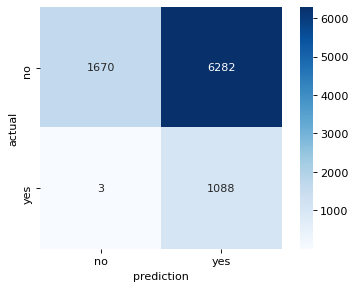

In [24]:
threshold=0.05
y_predict = (lm_model.predict_proba(X_test)[:, 1] >= threshold)
confusion = confusion_matrix(y_test, y_predict)
plt.figure(dpi=80)
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
xticklabels=['no', 'yes'],
yticklabels=['no', 'yes']);
plt.xlabel('prediction')
plt.ylabel('actual')

ROC AUC score =  0.9030663126329008


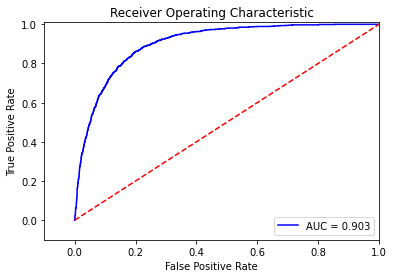

In [25]:
fpr,tpr,thresholds=roc_curve(y_test,lm_model.predict_proba(X_test)[:,1])

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
print("ROC AUC score = ", roc_auc_score(y_test, lm_model.predict_proba(X_test)[:,1]))

Log-loss on RandomForest

In [26]:
print("Log-loss on RandomForestClassifier accuracy: {:6.4f}".format(lm_model.score(X_test, y_test)))

Log-loss on RandomForestClassifier accuracy: 0.8771


In [27]:
# save the model to disk
pickle.dump(lm_model, open('lm_model.pkl', 'wb'))

#### KNN:

In [28]:
knn=KNeighborsClassifier(n_neighbors=3)
knn.fit(X_tr_rand,y_tr_rand)
y_pred=knn.predict(X_test)

accuracy_train_set = knn.score(X_tr_rand, y_tr_rand)  
accuracy_valid_set = knn.score(X_val_rand, y_val_rand)  


print("KNeighbors Classifier Model, Accuracy (Train Set) : ", accuracy_train_set)
print("KNeighbors Classifier Model, Accuracy (Val Set) : ", accuracy_valid_set)


KNeighbors Classifier Model, Accuracy (Train Set) :  0.9445073321327502
KNeighbors Classifier Model, Accuracy (Val Set) :  0.7160020581425264


In [29]:
print('Knn training metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy_score(y_tr_rand, knn.predict(X_tr_rand)),
         precision_score(y_tr_rand, knn.predict(X_tr_rand)),
         recall_score(y_tr_rand, knn.predict(X_tr_rand)),
         f1_score(y_tr_rand, knn.predict(X_tr_rand))
        )
     )
print('--------------------------------------')

print('Knn val metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy_score(y_val_rand, knn.predict(X_val_rand)),
         precision_score(y_val_rand, knn.predict(X_val_rand)),
         recall_score(y_val_rand, knn.predict(X_val_rand)),
         f1_score(y_val_rand, knn.predict(X_val_rand))
        )
     )

Knn training metrics: 
 Accuracy: 0.9445 
 Precision: 0.8646 
 Recall: 0.9926 
 F1: 0.9242
--------------------------------------
Knn val metrics: 
 Accuracy: 0.7160 
 Precision: 0.6157 
 Recall: 0.4438 
 F1: 0.5158


ROC AUC score =  0.6809240525647008


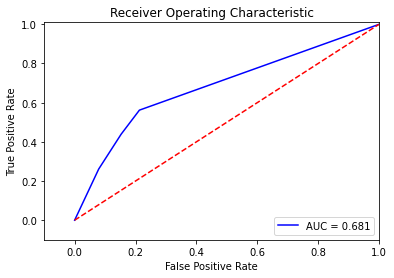

In [30]:
fpr,tpr,thresholds=roc_curve(y_test,knn.predict_proba(X_test)[:,1])

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
print("ROC AUC score = ", roc_auc_score(y_test, knn.predict_proba(X_test)[:,1]))

In [31]:
# save the model to disk
pickle.dump(knn, open('knn.pkl', 'wb'))

#### DecisionTreeClassifier:

In [32]:
dt = DecisionTreeClassifier()
dt.fit(X_tr_rand,y_tr_rand)
print('Accuracy on training set:',dt.score(X_tr_rand,y_tr_rand))
print('Accuracy on val set:',dt.score(X_val_rand,y_val_rand))

Accuracy on training set: 1.0
Accuracy on val set: 0.7685104193465397


In [33]:
print('DecisionTreeClassifier training metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy_score(y_tr_rand, dt.predict(X_tr_rand)),
         precision_score(y_tr_rand, dt.predict(X_tr_rand)),
         recall_score(y_tr_rand, dt.predict(X_tr_rand)),
         f1_score(y_tr_rand, dt.predict(X_tr_rand))
        )
     )

print('--------------------------------------')
print('DecisionTreeClassifier val metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy_score(y_val_rand, dt.predict(X_val_rand)),
         precision_score(y_val_rand, dt.predict(X_val_rand)),
         recall_score(y_val_rand, dt.predict(X_val_rand)),
         f1_score(y_val_rand, dt.predict(X_val_rand))
        )
     )

DecisionTreeClassifier training metrics: 
 Accuracy: 1.0000 
 Precision: 1.0000 
 Recall: 1.0000 
 F1: 1.0000
--------------------------------------
DecisionTreeClassifier val metrics: 
 Accuracy: 0.7685 
 Precision: 0.7654 
 Recall: 0.4626 
 F1: 0.5767


ROC AUC score =  0.6794063533354111


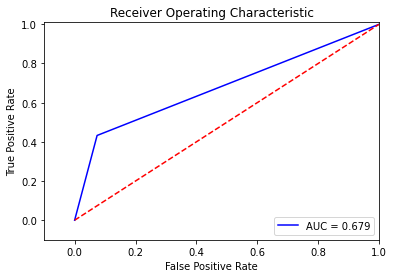

In [34]:
fpr,tpr,thresholds=roc_curve(y_test,dt.predict_proba(X_test)[:,1])

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
print("ROC AUC score = ", roc_auc_score(y_test, dt.predict_proba(X_test)[:,1]))

In [35]:
# save the model to disk
pickle.dump(dt, open('dt.pkl', 'wb'))

#### RandomForest:

In [36]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_tr_rand,y_tr_rand)
print('Accuracy on training set:',rf.score(X_tr_rand,y_tr_rand))
print('Accuracy on val ', rf.score(X_val_rand,y_val_rand))

Accuracy on training set: 1.0
Accuracy on val  0.7952662721893491


In [37]:
print('RandomForestClassifier training metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy_score(y_tr_rand, rf.predict(X_tr_rand)),
         precision_score(y_tr_rand, rf.predict(X_tr_rand)),
         recall_score(y_tr_rand, rf.predict(X_tr_rand)),
         f1_score(y_tr_rand, rf.predict(X_tr_rand))
        )
     )

print('--------------------------------------')
print('RandomForestClassifier val metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy_score(y_val_rand, rf.predict(X_val_rand)),
         precision_score(y_val_rand, rf.predict(X_val_rand)),
         recall_score(y_val_rand, rf.predict(X_val_rand)),
         f1_score(y_val_rand, rf.predict(X_val_rand))
        )
     )

RandomForestClassifier training metrics: 
 Accuracy: 1.0000 
 Precision: 1.0000 
 Recall: 1.0000 
 F1: 1.0000
--------------------------------------
RandomForestClassifier val metrics: 
 Accuracy: 0.7953 
 Precision: 0.8644 
 Recall: 0.4736 
 F1: 0.6119


ROC AUC score =  0.9166327018020128


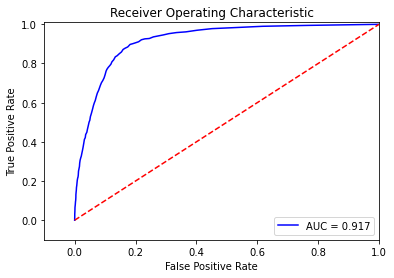

In [38]:
fpr,tpr,thresholds=roc_curve(y_test,rf.predict_proba(X_test)[:,1])

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
print("ROC AUC score = ", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

In [39]:
# save the model to disk
pickle.dump(rf, open('rf.pkl', 'wb'))

#### XGBClassifier:

In [40]:
xgb = XGBClassifier(n_estimators=100,max_deoth=3,learning_rate=.71)
xgb.fit(X_tr_rand, y_tr_rand)
print('Accuracy on training set:',xgb.score(X_tr_rand, y_tr_rand))

print('Accuracy on val set',xgb.score(X_val_rand, y_val_rand))

/Users/rawan/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_deoth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:29:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy on training set: 0.9838693079495755
Accuracy on val set 0.8290969899665552


In [41]:
print('XGBClassifier training metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy_score(y_tr_rand, xgb.predict(X_tr_rand)),
         precision_score(y_tr_rand, xgb.predict(X_tr_rand)),
         recall_score(y_tr_rand, xgb.predict(X_tr_rand)),
         f1_score(y_tr_rand, xgb.predict(X_tr_rand))
        )
     )

print('--------------------------------------')
print('XGBClassifier val metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy_score(y_val_rand, xgb.predict(X_val_rand)),
         precision_score(y_val_rand, xgb.predict(X_val_rand)),
         recall_score(y_val_rand, xgb.predict(X_val_rand)),
         f1_score(y_val_rand, xgb.predict(X_val_rand))
        ))

XGBClassifier training metrics: 
 Accuracy: 0.9839 
 Precision: 0.9664 
 Recall: 0.9869 
 F1: 0.9766
--------------------------------------
XGBClassifier val metrics: 
 Accuracy: 0.8291 
 Precision: 0.8311 
 Recall: 0.6258 
 F1: 0.7139


ROC AUC score =  0.9052316880199622


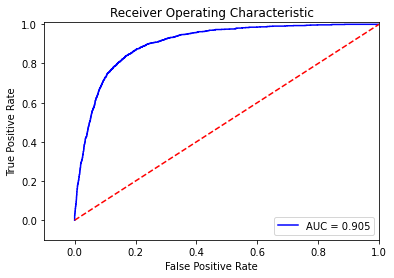

In [42]:
fpr,tpr,thresholds=roc_curve(y_test,xgb.predict_proba(X_test)[:,1])

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
print("ROC AUC score = ", roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1]))

In [43]:
# save the model to disk
pickle.dump(xgb, open('xgb.pkl', 'wb'))

#### BaggingClassifier:

In [44]:
bc= BaggingClassifier( n_estimators=30, random_state=0)
                           
bc.fit(X_tr_rand,  y_tr_rand)
accuracy_train_set = bc.score(X_tr_rand, y_tr_rand)  
accuracy_valid_set = bc.score(X_val_rand, y_val_rand) 

print("Bagging Classifier, Accuracy (Train Set) : ", accuracy_train_set)
print("Bagging Classifier, Accuracy (val Set) : ", accuracy_valid_set)

Bagging Classifier, Accuracy (Train Set) :  0.9998970928736814
Bagging Classifier, Accuracy (val Set) :  0.8012863390789812


# Hyperparameter Search

In [45]:
from sklearn.model_selection import GridSearchCV
parameters = {
    'C': np.linspace(1, 10, 10)
     
             }
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, cv=5, verbose=5, n_jobs=3)
clf.fit(X_tr_rand, y_tr_rand)
             


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/rawan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=3,
             param_grid={'C': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])},
             verbose=5)

In [46]:
clf.best_params_

{'C': 6.0}

### Classification Metrics Functions


In [47]:
def accuracy(actuals, preds):
    return np.mean(actuals == preds)

def precision(actuals, preds):
    tp = np.sum((actuals == 1) & (preds == 1))
    fp = np.sum((actuals == 0) & (preds == 1))
    return tp / (tp + fp)

def recall(actuals, preds):
    tp = np.sum((actuals == 1) & (preds == 1))
    fn = np.sum((actuals == 1) & (preds == 0))
    return tp / (tp + fn)

def F1(actuals, preds):
    p, r = precision(actuals, preds), recall(actuals, preds)
    return 2*p*r / (p + r)

# Feature Engineering

 #### Add new columns

In [48]:
data['new_columns']=data['y']*data['poutcome_success']

__Polynomial__:

In [49]:
poly_features_1 = PolynomialFeatures(degree=1)

X_train_poly1 = poly_features_1.fit_transform(X_tr_rand)
X_val_poly1 = poly_features_1.fit_transform(X_val_rand)

logisticRegr = LogisticRegression()
logisticRegr.fit(X_train_poly1, y_tr_rand)
print("Polynomial Regression Train Rˆ2:", logisticRegr.score(X_train_poly1,y_tr_rand))
print("Polynomial Regression Validate Rˆ2:", logisticRegr.score(X_val_poly1, y_val_rand))


Polynomial Regression Train Rˆ2: 0.7978389503473116
Polynomial Regression Validate Rˆ2: 0.8120915873424235


/Users/rawan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# importances extraction

In [50]:
lm_model = LogisticRegression(C=9,max_iter=3000,solver="lbfgs")
lm_model.fit(X_tr_rand, y_tr_rand)

accuracy_train_set = lm_model.score(X_tr_rand, y_tr_rand)  
accuracy_valid_set = lm_model.score(X_val_rand, y_val_rand)  
print("Logistic Regression Model, Accuracy (Train Set) : ", accuracy_train_set)
print("Logistic Regression Model, Accuracy (Val Set) : ", accuracy_valid_set)

Logistic Regression Model, Accuracy (Train Set) :  0.8252379727296115
Logistic Regression Model, Accuracy (Val Set) :  0.835271417545665


In [51]:
# importances extraction
importances = pd.DataFrame(data={
    'Attribute': X_tr_rand.columns,
    'Importance': lm_model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)
print(importances)

              Attribute  Importance
43     poutcome_success    1.947641
32            month_mar    1.366176
35            month_oct    1.127227
36            month_sep    0.832961
18          job_student    0.543730
15          job_retired    0.519633
25            month_apr    0.311454
27            month_dec    0.289822
39   education_tertiary    0.199595
10           job_admin.    0.174932
24       marital_single    0.093839
9              previous    0.025952
6              duration    0.005136
2               balance    0.000017
8                 pdays    0.000000
0                   age   -0.000103
5                   day   -0.001326
28            month_feb   -0.034215
20       job_unemployed   -0.045218
21          job_unknown   -0.066622
38  education_secondary   -0.078554
19       job_technician   -0.099639
7              campaign   -0.103634
14       job_management   -0.123145
1               default   -0.140584
40    education_unknown   -0.180567
22     marital_divorced   -0

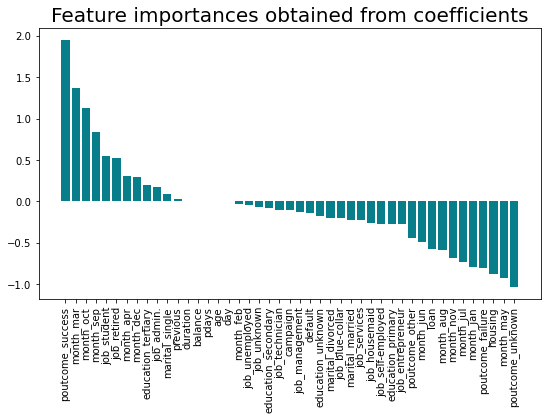

In [52]:
plt.figure(figsize = (9,5))
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [93]:
X_tr_rand_lm= X_tr_rand[['poutcome_success', 'job_retired', 'month_oct','month_mar', 'education_tertiary', 'month_sep', 'month_apr',
         'job_student', 'job_management', 'month_dec', 'month_aug','month_feb', 'marital_divorced', 
         'education_unknown', 'job_unemployed','duration','job_unknown', 'balance']]
X_val_rand_lm= X_val_rand[['poutcome_success', 'job_retired', 'month_oct','month_mar', 'education_tertiary', 'month_sep', 'month_apr',
         'job_student', 'job_management', 'month_dec', 'month_aug','month_feb', 'marital_divorced', 
         'education_unknown', 'job_unemployed','duration','job_unknown', 'balance']]

        
lm_model = LogisticRegression()
lm_model.fit(X_tr_rand_lm, y_tr_rand)
y_pred  = lm_model.predict(X_tr_rand_lm)

accuracy_train_set = lm_model.score(X_tr_rand_lm, y_tr_rand)  
accuracy_valid_set = lm_model.score(X_val_rand_lm, y_val_rand)  


print("Logistic Regression Model, Accuracy (Train Set) : ", accuracy_train_set)
print("Logistic Regression Model, Accuracy (Val Set) : ", accuracy_valid_set)

Logistic Regression Model, Accuracy (Train Set) :  0.8088500128633908
Logistic Regression Model, Accuracy (Val Set) :  0.8203241574479032


## Naive Bayes:

In [75]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
nb = GaussianNB()
nb.fit(X_tr_rand, y_tr_rand)

print('GaussianNB Model, Accuracy (Train Set) :',nb.score(X_tr_rand, y_tr_rand))

print('GaussianNB Model, Accuracy (Train Set) ',nb.score(X_val_rand, y_val_rand))

GaussianNB Model, Accuracy (Train Set) : 0.778698224852071
GaussianNB Model, Accuracy (Train Set)  0.7837921276048366


In [76]:
print('GaussianNB training metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy_score(y_tr_rand, nb.predict(X_tr_rand)),
         precision_score(y_tr_rand, nb.predict(X_tr_rand)),
         recall_score(y_tr_rand, nb.predict(X_tr_rand)),
         f1_score(y_tr_rand, nb.predict(X_tr_rand))
        )
     )

print('--------------------------------------')
print('GaussianNB val metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy_score(y_val_rand, nb.predict(X_val_rand)),
         precision_score(y_val_rand, nb.predict(X_val_rand)),
         recall_score(y_val_rand, nb.predict(X_val_rand)),
         f1_score(y_val_rand, nb.predict(X_val_rand))
        )
     )

GaussianNB training metrics: 
 Accuracy: 0.7787 
 Precision: 0.7311 
 Recall: 0.5547 
 F1: 0.6308
--------------------------------------
GaussianNB val metrics: 
 Accuracy: 0.7838 
 Precision: 0.7413 
 Recall: 0.5616 
 F1: 0.6391


# Summary of models

In [77]:
lm_model = LogisticRegression(solver="lbfgs", random_state=1)
knn = KNeighborsClassifier()
dt=DecisionTreeClassifier()
xgb= XGBClassifier()
rf = RandomForestClassifier(n_estimators=100, random_state=1)
bc= BaggingClassifier(n_estimators=30, random_state=0)
models = ["lm_model", "knn", "dt", "xgb",'rf','bc']

In [78]:
X_tr_rand.shape

(38870, 45)

In [79]:
y_tr_rand.shape

(38870,)

In [80]:
for model_name in models:
    
    curr_model = eval(model_name)
    
    curr_model.fit(X_tr_rand, y_tr_rand)
    
    with open(f"{model_name}.pickle", "wb") as pfile:
        pickle.dump(curr_model, pfile)

/Users/rawan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rawan/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:35:05] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [81]:
model_names =["lm_model", "knn", "dt", "xgb",'rf','bc']
for model_name in model_names:
    with open(f"{model_name}.pickle", "rb") as pfile:
        exec(f"{model_name} = pickle.load(pfile)")

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

In [82]:
model_list

[('lm_model', LogisticRegression(random_state=1)),
 ('knn', KNeighborsClassifier()),
 ('dt', DecisionTreeClassifier()),
 ('xgb',
  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=0.300000012, max_delta_step=0, max_depth=6,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
                reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
                tree_method='exact', validate_parameters=1, verbosity=None)),
 ('rf', RandomForestClassifier(random_state=1)),
 ('bc', BaggingClassifier(n_estimators=30, random_state=0))]

In [83]:
for model_name in model_names:
    curr_model = eval(model_name)
    print(f'{model_name} train_score: {curr_model.score(X_tr_rand, y_tr_rand)}')
    print(f'{model_name} val_score: {curr_model.score(X_val_rand, y_val_rand)}')
    print(f'{model_name} test_score: {curr_model.score(X_test, y_test)}')

lm_model train_score: 0.8017494211474144
lm_model val_score: 0.8121173141240031
lm_model test_score: 0.8657525157580449
knn train_score: 0.9030872137895549
knn val_score: 0.7178286596346797
knn test_score: 0.7762910538538096
dt train_score: 1.0
dt val_score: 0.7687162335991767
dt test_score: 0.8674112573261086
xgb train_score: 0.9409055827116027
xgb val_score: 0.8490095189091844
xgb test_score: 0.8853256662611965
rf train_score: 1.0
rf val_score: 0.7987393877025984
rf test_score: 0.8982638504920933
bc train_score: 0.9998970928736814
bc val_score: 0.8012863390789812
bc test_score: 0.8943934534999447


### Max Voting

In [84]:
voting_classifer = VotingClassifier(estimators=model_list,
                                    voting='hard', 
                                    n_jobs=-1)
voting_classifer.fit(X_tr_rand, y_tr_rand)

VotingClassifier(estimators=[('lm_model', LogisticRegression(random_state=1)),
                             ('knn', KNeighborsClassifier()),
                             ('dt', DecisionTreeClassifier()),
                             ('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            gpu_id=-1, importance_type='gain',
                                            interaction_constraints='',
                                            learning_rate=0.300000012,
                                            max_d...=6,
                                            min_child_weight=1, missing=nan,
                                            monotone_constraints='()',
                                            n_estimat

In [85]:
y_pred = voting_classifer.predict(X_tr_rand)
accuracy_score(y_tr_rand, y_pred)

0.9973244147157191

In [86]:
accuracy_score(y_test, voting_classifer.predict(X_test))


0.8977109366360722

In [87]:
y_pred=voting_classifer.predict(X_test)
print(metrics.confusion_matrix(y_test, y_pred));

[[7562  390]
 [ 535  556]]


<Figure size 360x360 with 0 Axes>

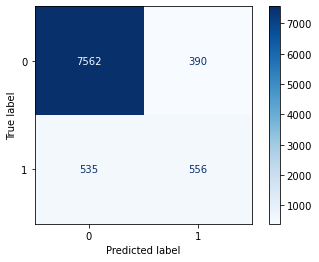

In [88]:
from sklearn.metrics import plot_confusion_matrix
plt.figure(figsize = (5,5))

plot_confusion_matrix(voting_classifer, X_test, y_test,  cmap=plt.cm.Blues)


In [89]:
models1 = []
accuracies1 = []
precisions1 = []
recalls1 = []
roc_scores1 = []
f1_scores1 = []

In [90]:
models_list=[lm_model,knn,rf,dt,xgb,bc]

In [91]:
model_names =["lm_model", "knn", "dt", "xgb",'rf','bc']

for model in models_list:
     
    accuracy = model.score(X_test, y_test)  #get accuracy
    y_pred1 = model.predict(X_test) #get predictions
    model_name = type(model).__name__
    print("Accuracy("+ model_name + "): ", accuracy.round(4)) #display accuracy
    print("F1 score("+ model_name + "): ", f1_score(y_test,y_pred1).round(4)) #display F1
    print("Precision("+ model_name + "): ", precision_score(y_test,y_pred1).round(4)) #display precision
    print("Recall("+ model_name + "): ",recall_score(y_test,y_pred1).round(4)) #display recall
    print("ROC Score("+ model_name + "): ",roc_auc_score(y_test,y_pred1).round(4)) #display recall
        

    models1.append(model_name)
    accuracies1.append(accuracy.round(4))
    f1_scores1.append(f1_score(y_test,y_pred1).round(4))
    precisions1.append(precision_score(y_test,y_pred1).round(4))
    recalls1.append(recall_score(y_test,y_pred1).round(4))
    roc_scores1.append(roc_auc_score(y_test,y_pred1).round(4))

Accuracy(LogisticRegression):  0.8658
F1 score(LogisticRegression):  0.5247
Precision(LogisticRegression):  0.458
Recall(LogisticRegression):  0.6141
ROC Score(LogisticRegression):  0.7572
Accuracy(KNeighborsClassifier):  0.7763
F1 score(KNeighborsClassifier):  0.3531
Precision(KNeighborsClassifier):  0.2711
Recall(KNeighborsClassifier):  0.506
ROC Score(KNeighborsClassifier):  0.6597
Accuracy(RandomForestClassifier):  0.8983
F1 score(RandomForestClassifier):  0.5267
Precision(RandomForestClassifier):  0.6002
Recall(RandomForestClassifier):  0.4693
ROC Score(RandomForestClassifier):  0.7132
Accuracy(DecisionTreeClassifier):  0.8674
F1 score(DecisionTreeClassifier):  0.4395
Precision(DecisionTreeClassifier):  0.4485
Recall(DecisionTreeClassifier):  0.4308
ROC Score(DecisionTreeClassifier):  0.6791
Accuracy(XGBClassifier):  0.8853
F1 score(XGBClassifier):  0.5909
Precision(XGBClassifier):  0.5187
Recall(XGBClassifier):  0.6865
ROC Score(XGBClassifier):  0.7996
Accuracy(BaggingClassifier)

In [92]:
result=pd.DataFrame({"Model" : models1, "Accuracy" : accuracies1,"F1" : f1_scores1, "Precision" : precisions1, "Recall" : recalls1, 'ROC Score' :roc_scores1})
result

,Model,Accuracy,F1,Precision,Recall,ROC Score
0,LogisticRegression,0.8658,0.5247,0.4580,0.6141,0.7572
1,KNeighborsClassifier,0.7763,0.3531,0.2711,0.5060,0.6597
2,RandomForestClassifier,0.8983,0.5267,0.6002,0.4693,0.7132
3,DecisionTreeClassifier,0.8674,0.4395,0.4485,0.4308,0.6791
4,XGBClassifier,0.8853,0.5909,0.5187,0.6865,0.7996
5,BaggingClassifier,0.8944,0.5497,0.5660,0.5344,0.7391
